In [61]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import scipy
import scipy.signal
import librosa
import soundfile as sf

In [2]:
def plotSignal(samples, title=None, show=True, axis=True):
    plt.figure(figsize=[15, 5])
    plt.plot(samples)
    if(title != None):
        plt.title(title)
    if(not axis):
        plt.axis('off')
    if(show):
        plt.show()

def normalizeWav(y, ymax=None, ymin=None):
    if(not ymax):
        ymax = np.max(y)
    if(not ymin):
        ymin = np.min(y)
    ymin = np.abs(ymin)
    ny = np.where(y > 0, y / ymax, y / ymin)
    return ny

def getFrames(samples, sampling_rate, win_len_fr, win_hop_fr):
    overlap_fr = win_len_fr - win_hop_fr
    n_frames = (len(samples) - overlap_fr) // win_hop_fr
    frames_left = (len(samples) - overlap_fr) % win_hop_fr
    samples = samples.copy()
    if(frames_left > 0):
        pad = np.zeros((win_hop_fr - frames_left, ))
        samples = np.append(samples, pad)
        n_frames += 1
    frames = []
    for i in range(n_frames):
        frames.append(samples[win_hop_fr * i: win_hop_fr * i + win_len_fr])
    return np.array(frames)

# Question 1

In [3]:
def idealResonatorZF(x):
    y = np.zeros(x.shape)
    for i in range(2, x.shape[0]):
        y[i] = -(-2 * y[i - 1] + 1 * y[i - 2]) + x[i]
    return y

def trendRemoval(x, wlen):
    if(wlen % 2 == 0):
        wlen += 1
    fil = np.ones((wlen, )) / wlen
    x_avg = np.convolve(x, fil, mode="valid")
    return x[(wlen >> 1): -(wlen >> 1)] - x_avg

def getEpochZFF(samples, fs, pad=False):
    smooth_time = 10 # ms
    smooth_size = int(fs * smooth_time / 1000)
    x = np.diff(samples, prepend=samples[0])
    y1 = idealResonatorZF(x)
    y2 = idealResonatorZF(y1)
    y = trendRemoval(y2, smooth_size)
    y = trendRemoval(y, smooth_size)
    if(pad):
        opad = smooth_size - (smooth_size % 2)
        y = np.hstack([np.zeros((opad, )), y, np.zeros((opad, ))])
    return y

In [4]:
def getDifferencedEGG(egg):
    return np.diff(egg, prepend=egg[0])

def getGCI(epoch):
    ndiff = np.diff(epoch)
    sdiff = np.diff(np.signbit(epoch))
    zcr = np.where(sdiff == 1)[0]
    valid_zcr = np.where(ndiff[zcr] > 0)[0]
    return zcr[valid_zcr]

In [5]:
raw_samples, fs = librosa.load("./audio/arctic_a0045.wav", sr=16000, mono=False)
samples, egg = raw_samples[0, :], raw_samples[1, :]
degg = getDifferencedEGG(egg)

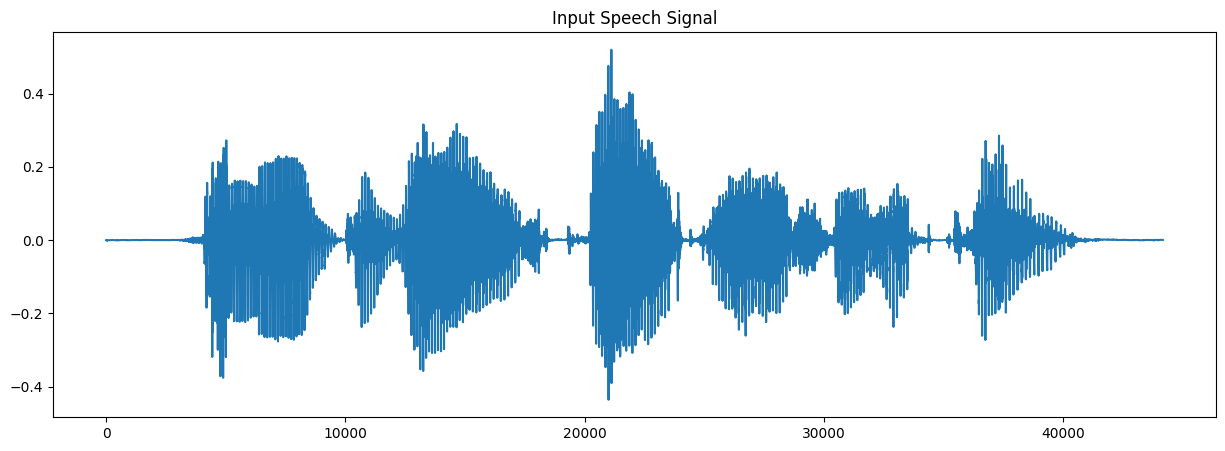

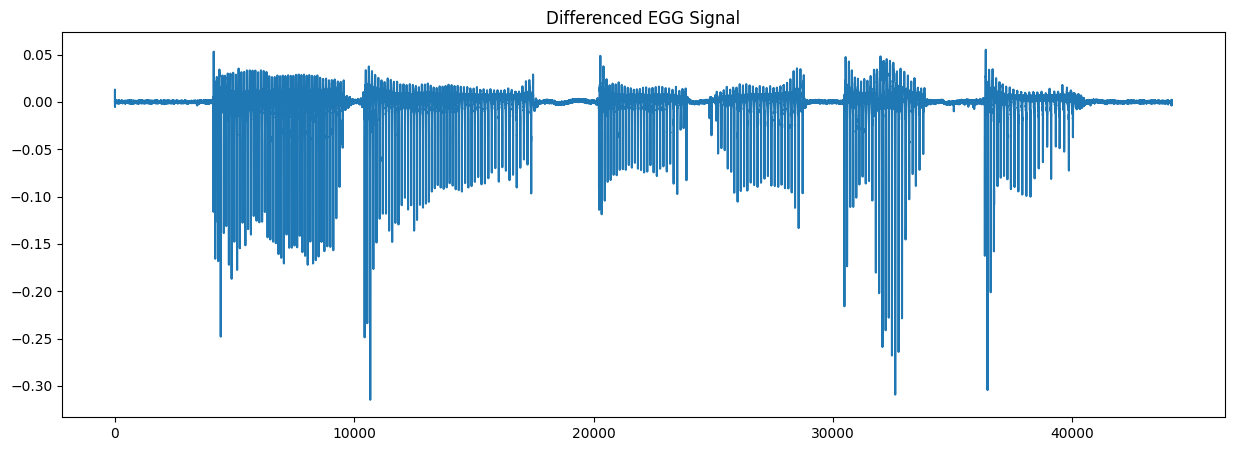

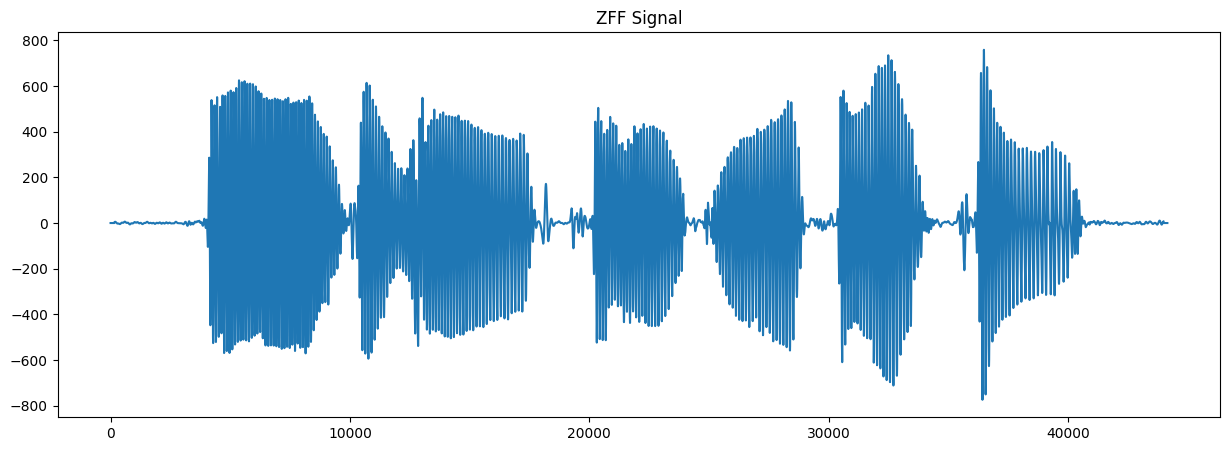

In [6]:
epoch = getEpochZFF(samples, fs, pad=True)
plotSignal(samples, title="Input Speech Signal")
plotSignal(degg, title="Differenced EGG Signal")
plotSignal(epoch, title="ZFF Signal")

We can zoom-in to look at particular regions. Here i even marked the GCI in red.

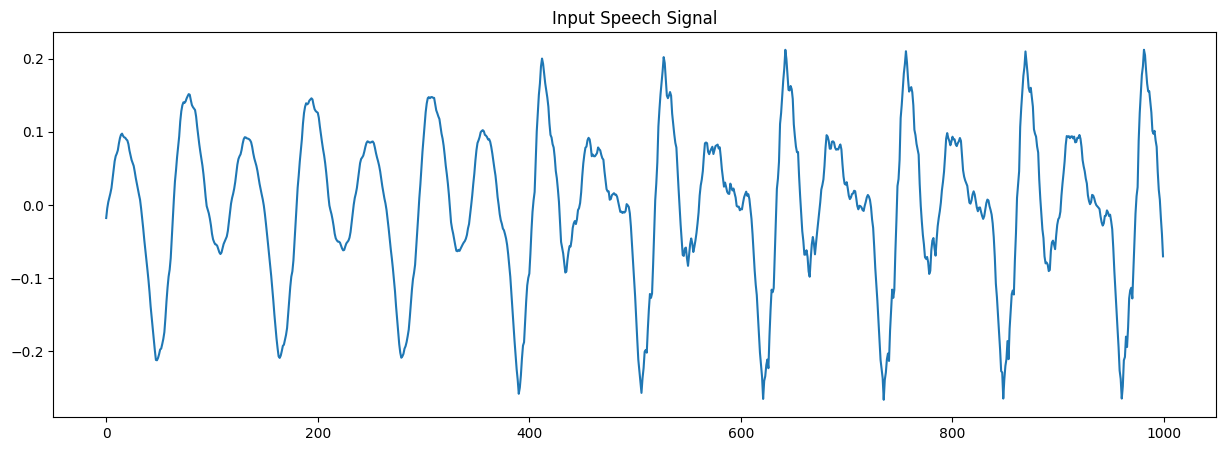

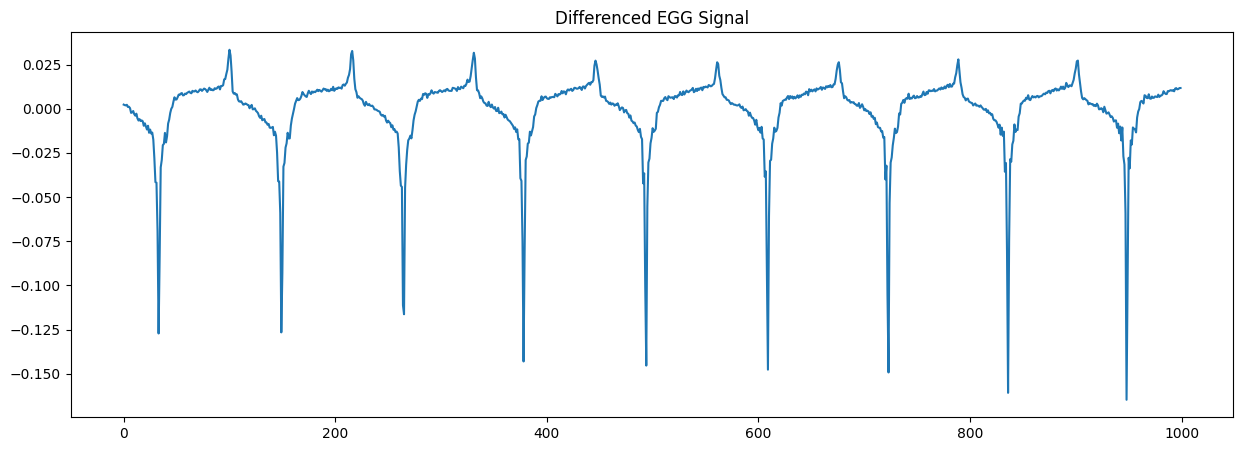

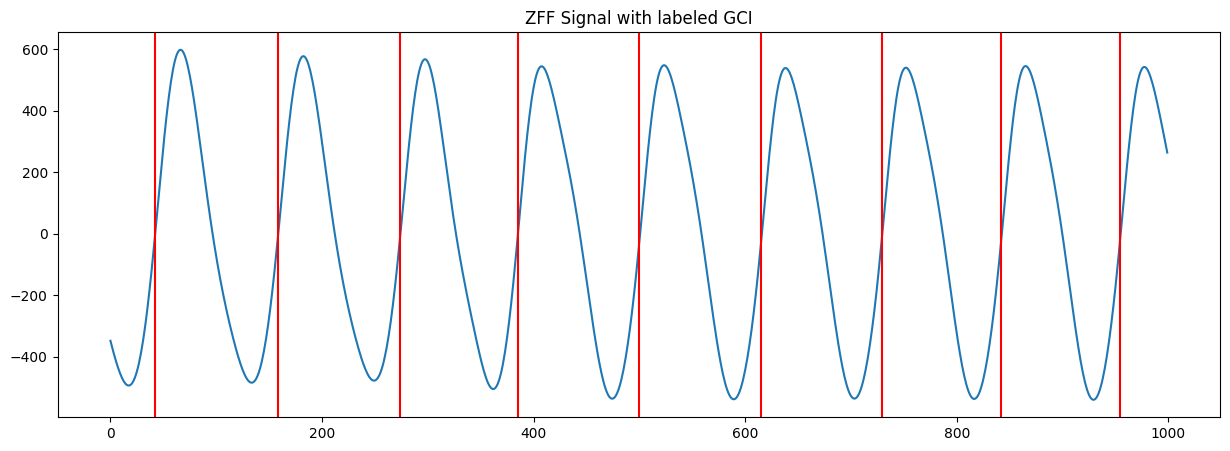

In [7]:
s_start, s_end = 6000, 7000
plotSignal(samples[s_start: s_end], title="Input Speech Signal")
plotSignal(degg[s_start: s_end], title="Differenced EGG Signal")
plotSignal(epoch[s_start: s_end], title="ZFF Signal with labeled GCI", show=False)
for gci in getGCI(epoch[s_start: s_end]):
    plt.axvline(x = gci, color = 'r')
plt.show()

# Question 2

In [8]:
samples, fs = librosa.load("./audio/name.wav", sr=16000)
samples = samples[10000: 64000]
frames = getFrames(samples, fs, 512, 256)

In [9]:
def getLPResidue(signal):
    lpc = librosa.lpc(signal, order=10)
    lpc = np.hstack([[0], -1 * lpc[1:]])
    signal_pred = scipy.signal.lfilter(lpc, [1], signal)
    return signal_pred - signal

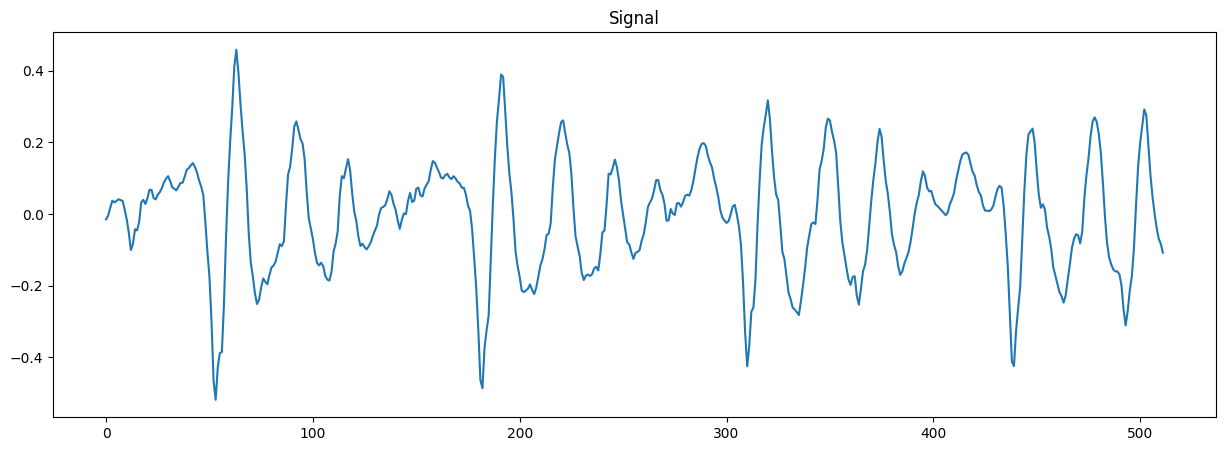

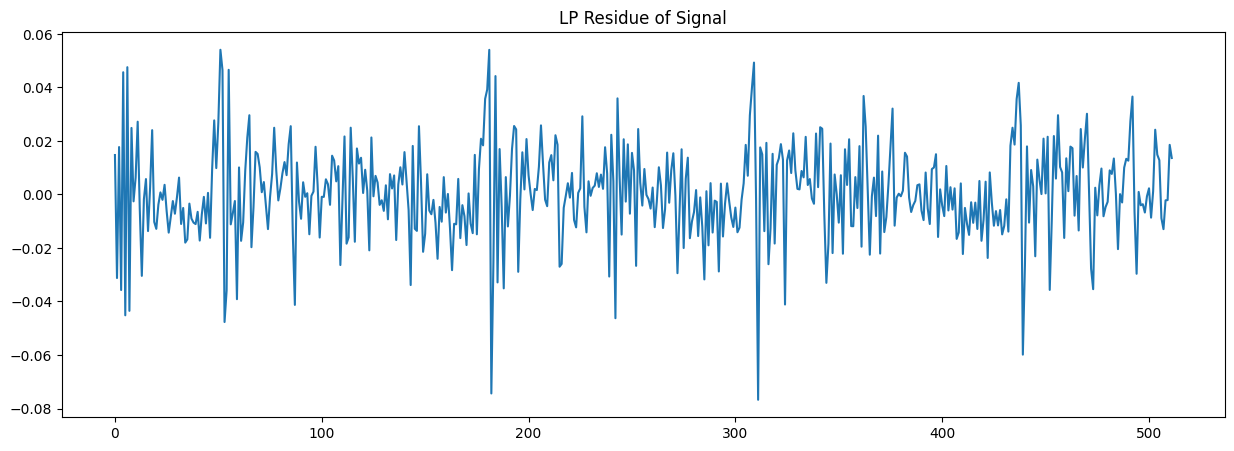

In [11]:
plotSignal(frames[20], "Signal")
plotSignal(getLPResidue(frames[20]), "LP Residue of Signal")

In [12]:
img = []
for ind, frame in enumerate(frames):
    e_n = getLPResidue(frame)
    rcc = librosa.feature.mfcc(y=e_n, sr=fs, n_mfcc=13, n_fft=e_n.shape[0])[:, 0]
    img.append(rcc.reshape(-1, 1))
img = np.hstack(img)

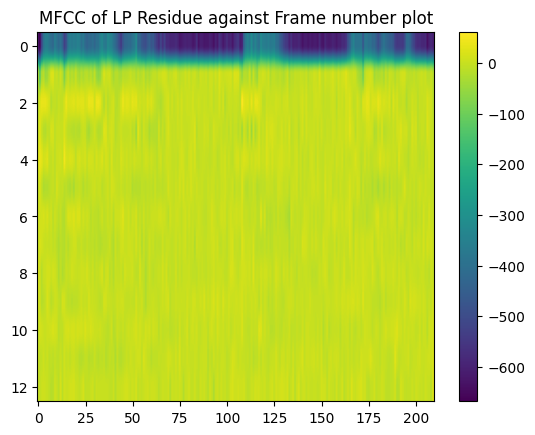

In [14]:
plt.imshow(img, aspect="auto")
plt.title("MFCC of LP Residue against Frame number plot")
plt.colorbar()
plt.show()

MFCC models the vocal tract. We can see that the first coefficient is very low when compared to the other 12 coefficients.

# Question 3

I implemented VOP (vowel-onset-point) calculation using Spectral Peaks.

In [18]:
def getVOP(signal, fs):
    frames = getFrames(signal, fs, int(fs * 0.020), int(fs * 0.010))
    n_fft = 256
    tsums = []
    for ind, frame in enumerate(frames):
        fdft = np.real(np.fft.fft(frame, n=n_fft))[: (n_fft >> 1)]
        top_ind = np.argpartition(fdft, -10)[-10: ]
        top_sum = np.sum(fdft[top_ind])
        tsums.append(top_sum)
    tsums = np.array(tsums)
    tsums = scipy.signal.resample(tsums, signal.shape[0])
    window = np.ones(800) / 800
    tsums = np.convolve(tsums, window, mode="same")
    tsums = np.convolve(tsums, window, mode="same")
    fogd = scipy.ndimage.gaussian_filter1d(tsums, 1, order=1)
    fogd = np.convolve(fogd, window, mode="same")
    fogd = np.convolve(fogd, window, mode="same")
    peaks = scipy.signal.find_peaks(fogd)[0]
    mapeak = np.max(np.abs(fogd[peaks]))
    valid_peaks = peaks[np.where(np.abs(fogd[peaks]) > 0.01 * mapeak)[0]]
    return valid_peaks

I used a test sentence for showing each code functionality.

In [19]:
samples, fs = librosa.load("./audio/vop_test.wav", sr=16000)
samples = samples[3000: 40000]

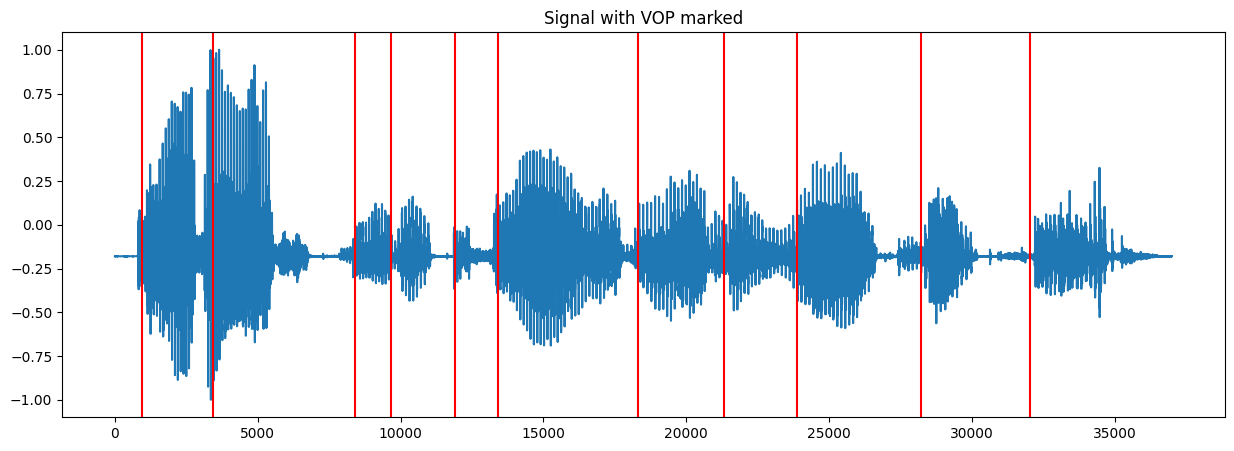

In [20]:
vop_peaks = getVOP(samples, fs)
plotSignal(samples, show=False, title="Signal with VOP marked")
for peak in vop_peaks:
    plt.axvline(x = peak, color = 'r')
plt.show()

A frame is determined as Voiced or Unvoiced by adding noise to it and calculating GCis for both the original and the noisy signal.  
Depending on the drift in GCI, we decide if the frame is Voiced or not.

The pitch of a frame is calculated by finding the GCIs, then calculate the average distance between two successive GCIs, which corresponds to one Pitch cycle length. From this we can find the Pitch.

In [21]:
def isVoicedFrame(frame, fs):
    epoch1 = getEpochZFF(frame, fs)
    nframe = frame + np.random.normal(0, np.abs(np.mean(frame)) * 0.1, size=frame.shape[0])
    epoch2 = getEpochZFF(nframe, fs)
    gci1 = getGCI(epoch1)
    gci2 = getGCI(epoch2)
    if(not (gci1.shape[0] > 0 and gci2.shape[0] > 0)):
        return False
    elif(gci1.shape != gci2.shape):
        return False
    elif(np.mean(np.abs(gci1 - gci2)) > 10):
        return False
    return True

def getPitchFrame(eframe, fs):
    gci = getGCI(eframe)
    if(gci.shape[0] > 1):
        pitch_len = np.mean(np.diff(gci))
        return fs / pitch_len
    else:
        return 0

Here I marked the Voiced and Unvoiced region for the test audio to show the results of the algorithm.

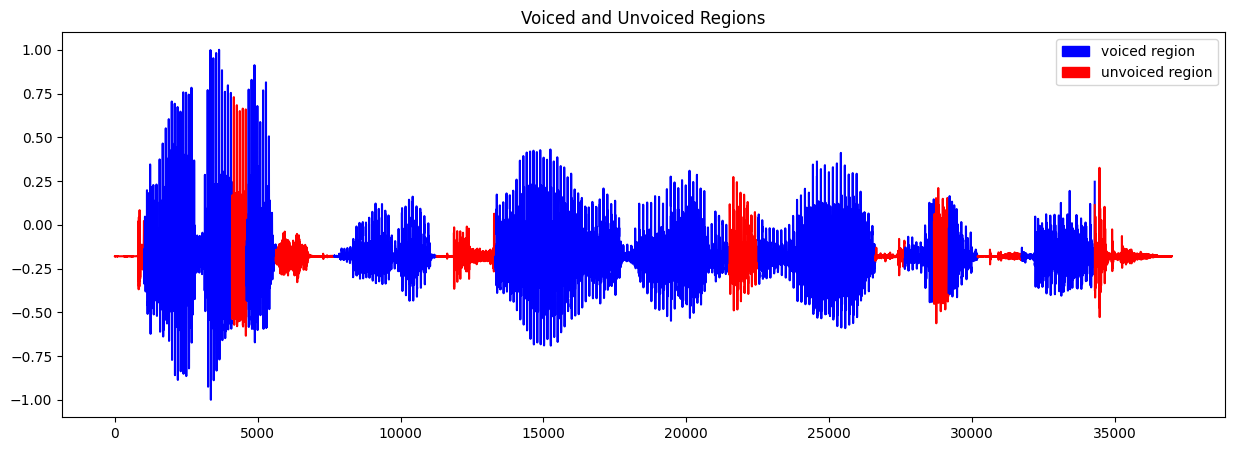

In [22]:
def markVUVRegion(signal, fs):
    frames = getFrames(signal, fs, 512, 512)
    vframes = []
    plt.figure(figsize=[15, 5])
    plt.title("Voiced and Unvoiced Regions")
    for ind, frame in enumerate(frames):
        if(isVoicedFrame(frame, fs)):
            plt.plot(np.arange(ind * 512, min(signal.shape[0], (ind + 1) * 512), 1), signal[ind * 512: (ind + 1) * 512], color='b')
        else:
            plt.plot(np.arange(ind * 512, min(signal.shape[0], (ind + 1) * 512), 1), signal[ind * 512: (ind + 1) * 512], color='r')
    blue_patch = mpatches.Patch(color='blue', label='voiced region')
    red_patch = mpatches.Patch(color='red', label='unvoiced region')
    plt.legend(handles=[blue_patch, red_patch])
    plt.show()

markVUVRegion(samples, fs)

The getProsody function plots the voiced parts of signal with pitch contour and prints the prosody features for the given signal.

In [23]:
def getProsody(signal, fs):
    frames = getFrames(signal, fs, 512, 512)
    vframes = []
    for ind, frame in enumerate(frames):
        if(isVoicedFrame(frame, fs)):
            vframes.append(frame)
    vframes = np.hstack(vframes)
    vop_peaks = getVOP(vframes, fs)
    epoch = getEpochZFF(vframes, fs, pad=True)
    epoch_frames = getFrames(epoch, fs, 512, 512)
    pitches = []
    for ind, eframe in enumerate(epoch_frames):
        pitches.append(getPitchFrame(eframe, fs))
    plotSignal(vframes * max(pitches), show=False, title="Voiced Region with VOP and Pitch Contour")
    for peak in vop_peaks:
        plt.axvline(x = peak, color = 'r')
    for ind, pitch in enumerate(pitches):
        plt.plot(ind * 512, pitch, 'o', color='purple')
    pitches = scipy.signal.resample(pitches, vframes.shape[0])
    plt.plot(pitches)
    plt.show()

    del_f0_avg = []
    dist_f0_avg = []
    At_avg = []
    Dt_avg = []
    dist_vop_avg = []
    log_energy_avg = []

    for i in range(0, len(vop_peaks) - 1):
        fcurve = pitches[vop_peaks[i]: vop_peaks[i + 1]]
        # 1. Change in F0
        del_f0 = np.max(fcurve) - np.min(fcurve)
        del_f0_avg.append(del_f0)
        # 2. Distance of F0 peak wrt to VOP
        max_pk = np.argmax(fcurve)
        dist_f0 = max_pk / fs
        dist_f0_avg.append(dist_f0)
        # 3. Amplitude Tilt
        Ar = np.abs(np.max(fcurve) - fcurve[0])
        Af = np.abs(np.max(fcurve) - fcurve[-1])
        At = (Ar - Af) / (Ar + Af)
        At_avg.append(At)
        # 4. Duration Tilt
        Dr = np.abs(max_pk / fs)
        Df = np.abs((fcurve.shape[0] - max_pk) / fs)
        Dt = (Dr - Df) / (Dr + Df)
        Dt_avg.append(Dt)
        # 5. Distance VOP
        dist_vop = Dr + Df
        dist_vop_avg.append(dist_vop)
        # 7. Change in log energy
        log_energy = np.log(np.sum(np.power(fcurve, 2)))
        log_energy_avg.append(log_energy)

    del_f0_avg = np.mean(del_f0_avg)
    print("Prosody Features-")
    print("Change in F0:", del_f0_avg)
    dist_f0_avg = np.mean(dist_f0_avg)
    print("Distance of F0 peak with respect to VOP:", dist_f0_avg)
    At_avg = np.mean(At_avg)
    print("Amplitude Tilt:", At_avg)
    Dt_avg = np.mean(Dt_avg)
    print("Duration Tilt:", Dt_avg)
    dist_vop_avg = np.mean(dist_vop_avg)
    print("Distance between successive VOP:", dist_vop_avg)

    dur_voiced = len(vframes) / fs
    print("Duration of Voiced Region:", dur_voiced)
    log_energy_avg = np.mean(np.abs(np.diff(log_energy_avg)))
    print("Change in Log Energy in Voiced Region:", log_energy_avg)

Below is the output of getProsody for the test audio.

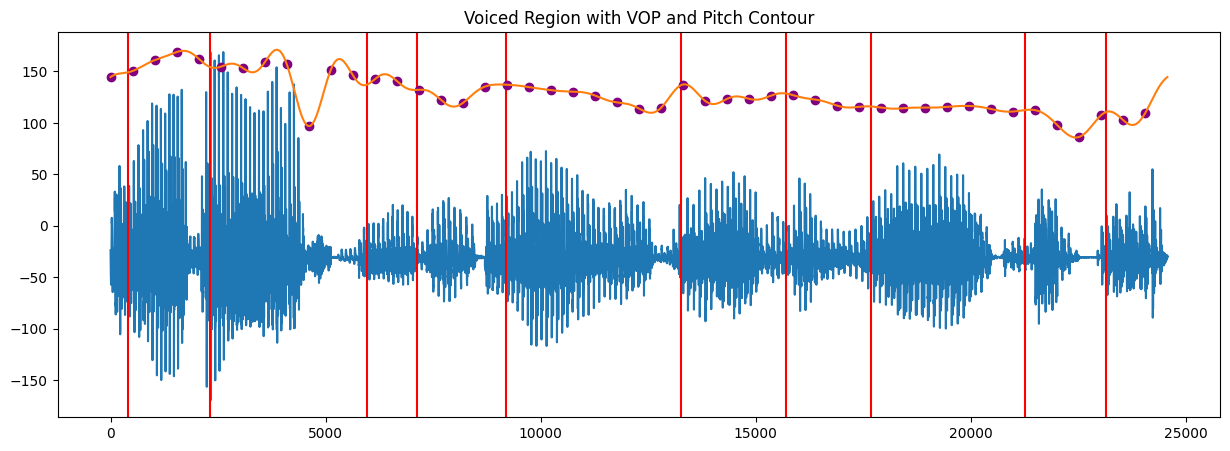

Prosody Features-
Change in F0: 24.944057106945998
Distance of F0 peak with respect to VOP: 0.05245138888888889
Amplitude Tilt: -0.4190098831285154
Duration Tilt: -0.31288315755816104
Distance between successive VOP: 0.15793055555555557
Duration of Voiced Region: 1.536
Change in Log Energy in Voiced Region: 0.6185564211602546


In [24]:
getProsody(samples, fs)

I used this Hindi sentence "thum aaj bohathi khuubsurath laghrahi ho", and had 4 native speakers of Hindi, Tamil, Telugu and Marathi speak it.
I used these 4 speech signals to compare prosody.

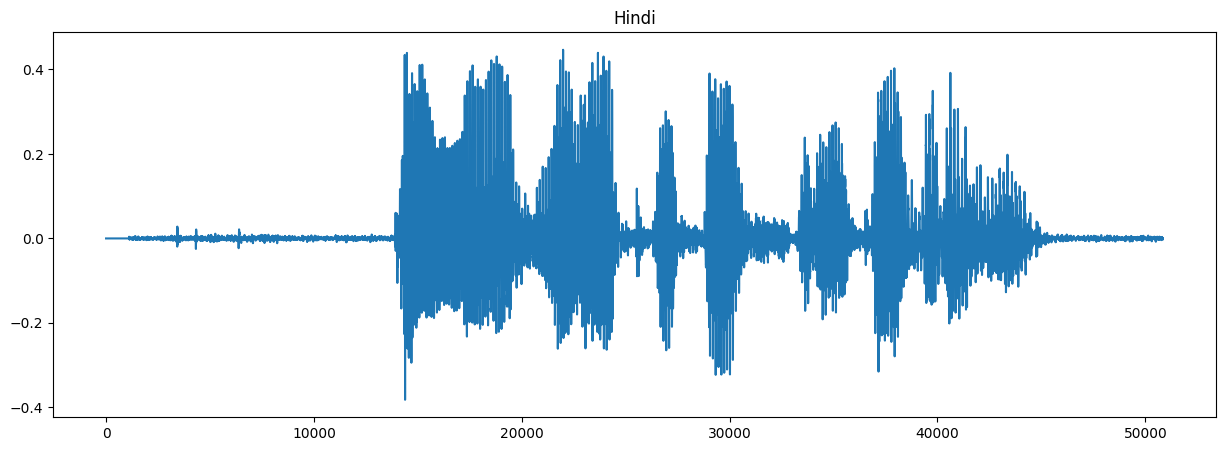

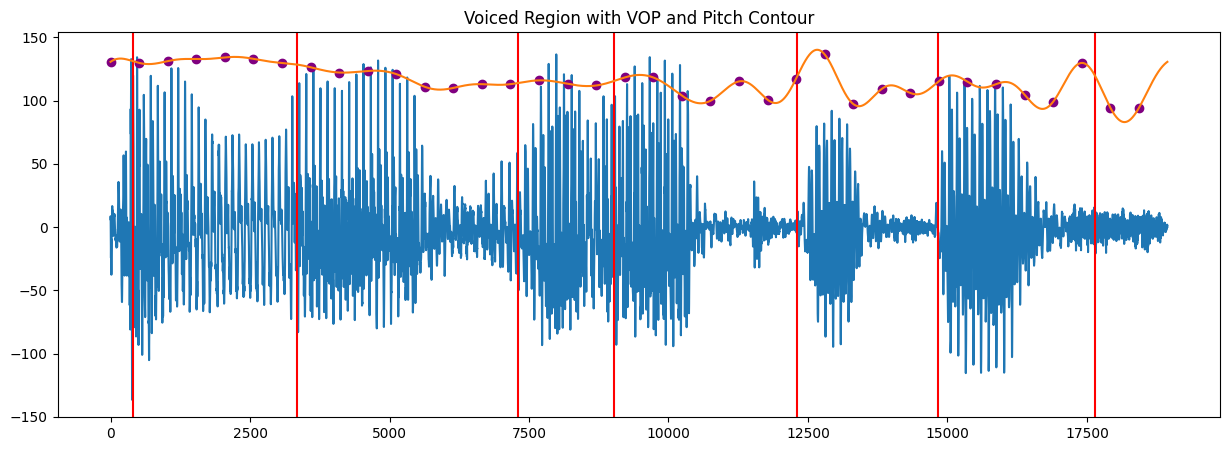

Prosody Features-
Change in F0: 22.296254382974364
Distance of F0 peak with respect to VOP: 0.05881250000000001
Amplitude Tilt: 0.013167761884357046
Duration Tilt: -0.3112522132455855
Distance between successive VOP: 0.17961458333333333
Duration of Voiced Region: 1.184
Change in Log Energy in Voiced Region: 0.3584008632857071


In [25]:
samples_hin, fs_hin = librosa.load("./audio/hindi.wav", sr=16000)
plotSignal(samples_hin, title="Hindi")
samples_hin = normalizeWav(samples_hin[14000: 33000])
getProsody(samples_hin, fs_hin)

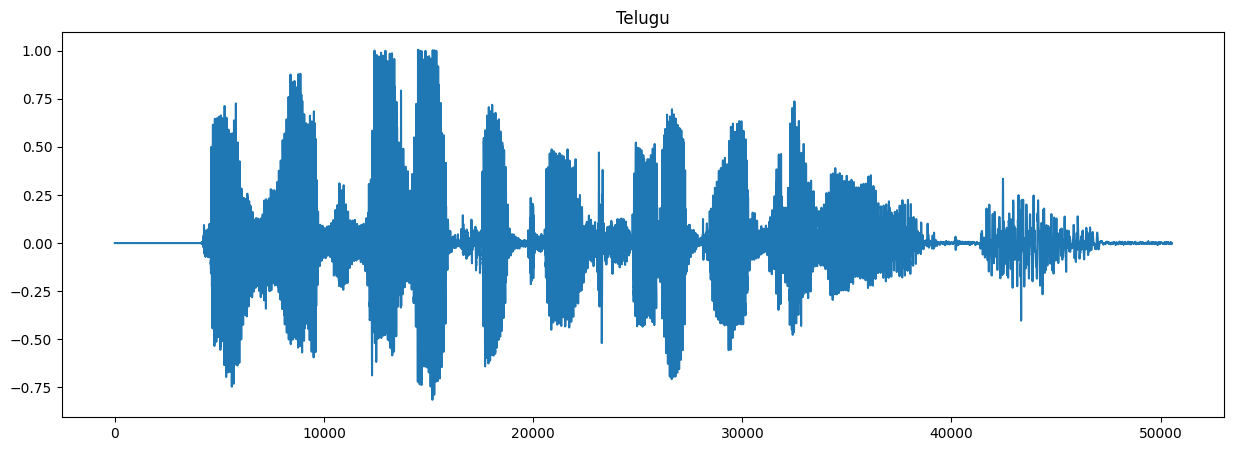

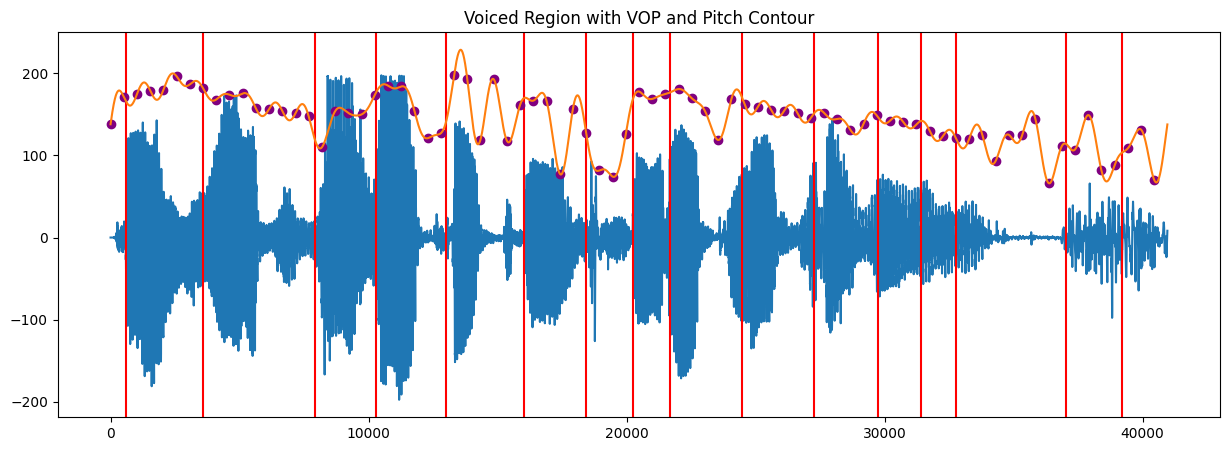

Prosody Features-
Change in F0: 59.13319277103711
Distance of F0 peak with respect to VOP: 0.05325833333333333
Amplitude Tilt: -0.17333511315426503
Duration Tilt: -0.32496916735704506
Distance between successive VOP: 0.1607875
Duration of Voiced Region: 2.56
Change in Log Energy in Voiced Region: 0.5147049129015936


In [26]:
samples_tel, fs_tel = librosa.load("./audio/telugu.wav", sr=16000)
plotSignal(samples_tel, title="Telugu")
samples_tel = normalizeWav(samples_tel[4000: 46000])
getProsody(samples_tel, fs_tel)

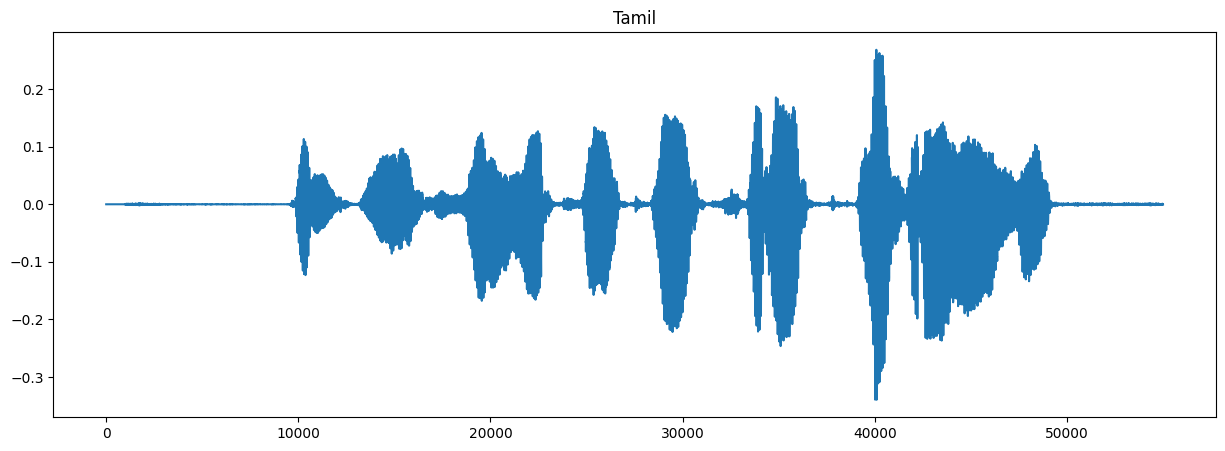

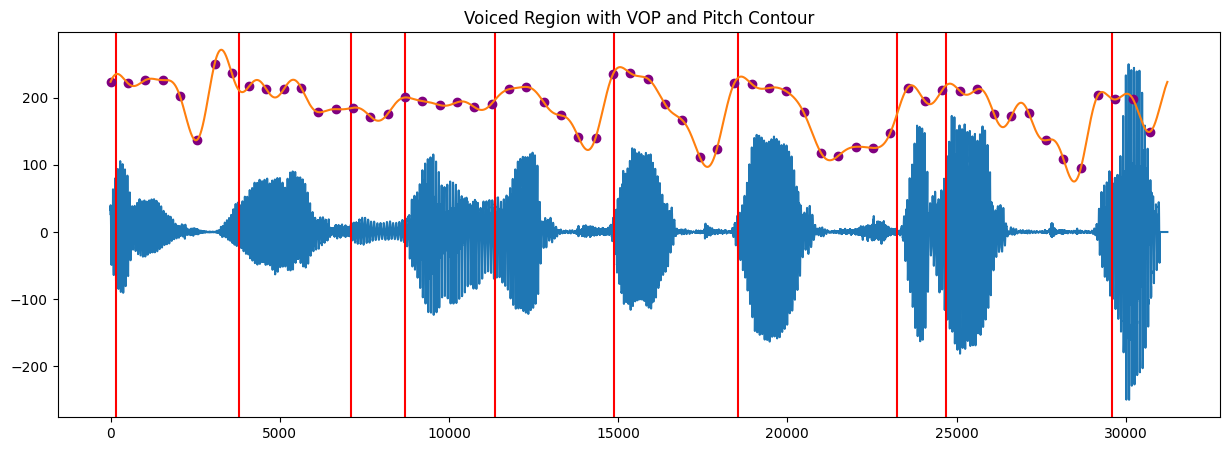

Prosody Features-
Change in F0: 90.5300412251464
Distance of F0 peak with respect to VOP: 0.08125694444444444
Amplitude Tilt: -0.09298376992468542
Duration Tilt: -0.01241877297482837
Distance between successive VOP: 0.20427777777777778
Duration of Voiced Region: 1.952
Change in Log Energy in Voiced Region: 0.47980533076868603


In [27]:
samples_tam, fs_tam = librosa.load("./audio/tamil.wav", sr=16000)
plotSignal(samples_tam, title="Tamil")
samples_tam = normalizeWav(samples_tam[10000: 41000])
getProsody(samples_tam, fs_tam)

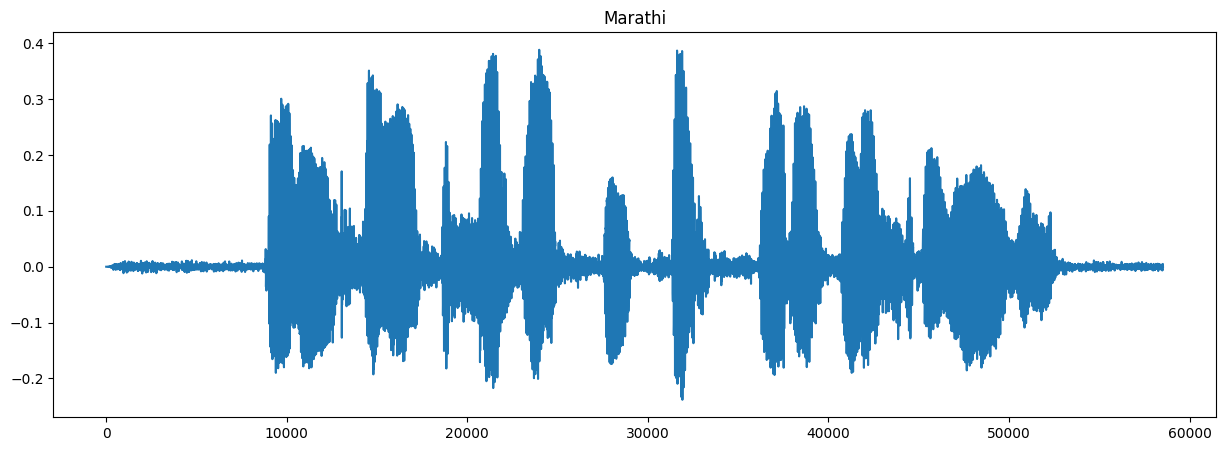

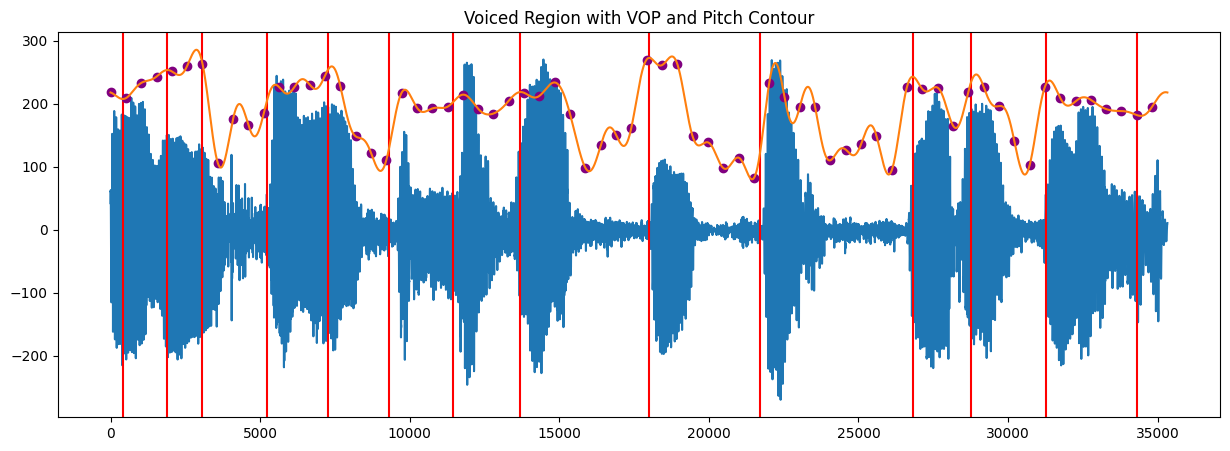

Prosody Features-
Change in F0: 111.27309797432576
Distance of F0 peak with respect to VOP: 0.06391826923076922
Amplitude Tilt: 0.07046590329840939
Duration Tilt: -0.142802081439166
Distance between successive VOP: 0.16301923076923078
Duration of Voiced Region: 2.208
Change in Log Energy in Voiced Region: 0.30885310589833753


In [30]:
samples_mar, fs_mar = librosa.load("./audio/marathi.wav", sr=16000)
plotSignal(samples_mar, title="Marathi")
samples_mar = normalizeWav(samples_mar[9000: 45000])
getProsody(samples_mar, fs_mar)

### Results Table for Prosody: 

| Language | Change in F0 | Distance F0-VOP | Amplitude Tilt | Duration Tilt | Distance VOP-VOP | Voiced Duration | Change in Log Energy |
|   :---:  |    :--:   |       :--:      |      :---:     |      :--:     |       :---:      |      :---:      |       :----:      |
|Hindi|22.296|0.058|0.013|-0.311|0.179|1.184|0.358|
|Telugu|59.133|0.053|-0.173|-0.324|0.160|2.56|0.514|
|Tamil|90.530|0.081|-0.092|-0.012|0.204|1.952|0.479|
|Marathi|111.273|0.063|0.070|-0.142|0.163|2.208|0.308|

The change in F0 is quite substantial for Telugu, Tamil and Marathi.  
Distance between F0 peak and the corresponding VOP is almost consistent but increases slightly for Tamil.  
Amplitude tilt is quite varying for all languages.  
Duration tilt is negative for all languages but Tamil has relatively higher value.  
The distance between consecutive VOPs is pretty consistent for every langauge.  
The voiced duration is different for each language.  
The change in log energy in voiced region are close to each other language.

# Question 4

The clean original audio is in `audio/original_q4.wav`.

In [62]:
def addNoiseToWav(inpath, snr, outpath):
    signal, fs = librosa.load(inpath)
    rms_audio = np.sqrt(np.mean(signal**2))
    rms_noise = np.sqrt(rms_audio ** 2 / np.power(10, snr / 10))
    noise = np.random.normal(0, rms_noise, signal.shape[0])
    sf.write(outpath, signal + noise, fs)

In [75]:
addNoiseToWav("audio/original_q4.wav",  0, "audio/snr00_q4.wav")
addNoiseToWav("audio/original_q4.wav", 10, "audio/snr10_q4.wav")
addNoiseToWav("audio/original_q4.wav", 20, "audio/snr20_q4.wav")

We add noise to the original audio to get desired SNR.  
We save the signal with SNR  0 in `audio/snr00_q4.wav`.  
We save the signal with SNR 10 in `audio/snr10_q4.wav`.  
We save the signal with SNR 20 in `audio/snr20_q4.wav`.  

The spectral subtraction code for question 4 is written in MATLAB and hence is seperate in `q4_spec_sub.m`.  
We perform spectral subtraction using v_specsub function from voicebox toolkit in MATLAB.

We clean the noisy signals using the above code.  
We save the clean signal of `audio/snr00_q4.wav` in `audio/snr00_clean_q4.wav`.  
We save the clean signal of `audio/snr10_q4.wav` in `audio/snr10_clean_q4.wav`.  
We save the clean signal of `audio/snr20_q4.wav` in `audio/snr20_clean_q4.wav`.  

In [79]:
def plotMFCC(signal, fs):
    plt.figure(figsize=[15, 5])
    mfccs = librosa.feature.mfcc(y=signal, sr=fs, n_mfcc=13, n_fft=512)
    plt.imshow(mfccs, aspect="auto")
    plt.title("MFCC plot")
    plt.colorbar()
    plt.show()

### Original Signal

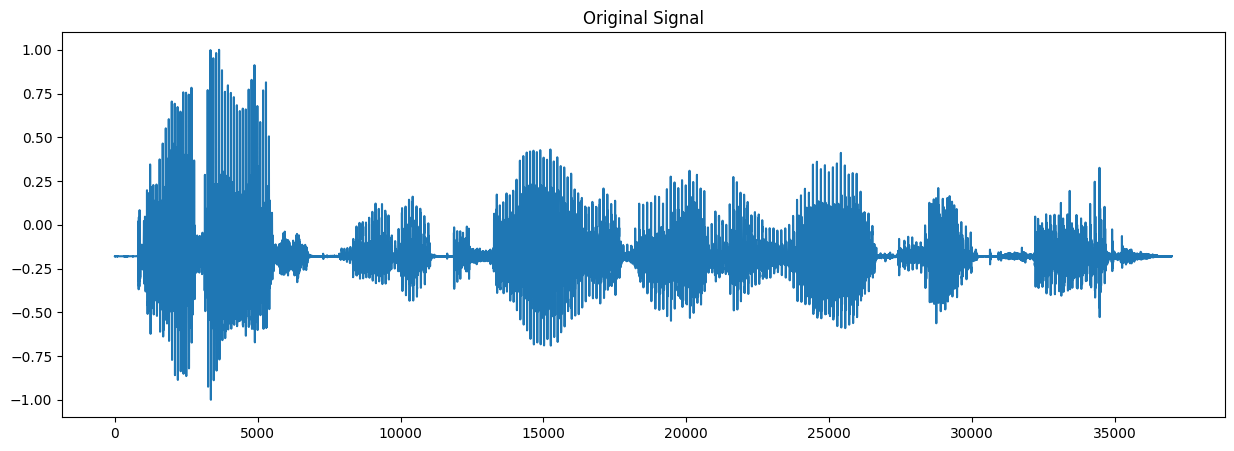

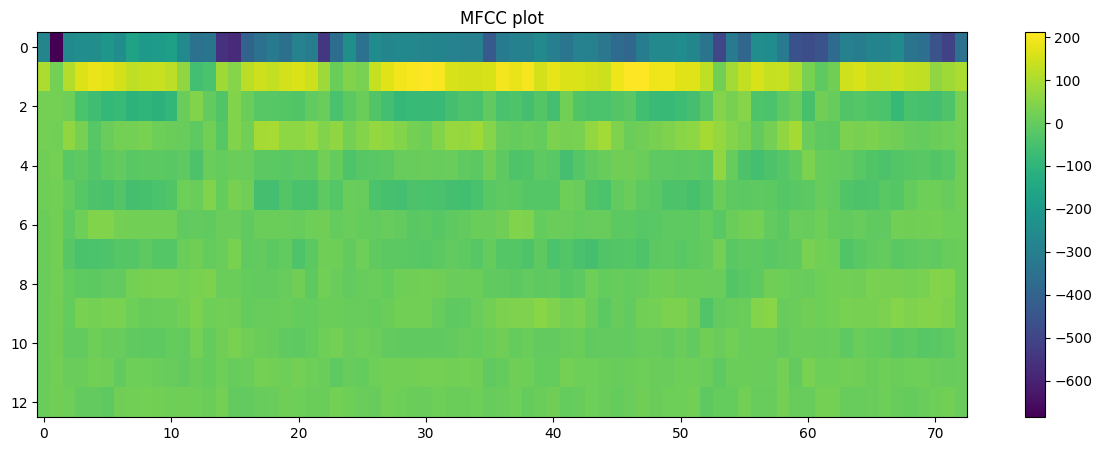

In [80]:
samples, fs = librosa.load("./audio/original_q4.wav", sr=16000)
plotSignal(samples, title="Original Signal")
plotMFCC(samples, fs)

### 0 SNR Signal

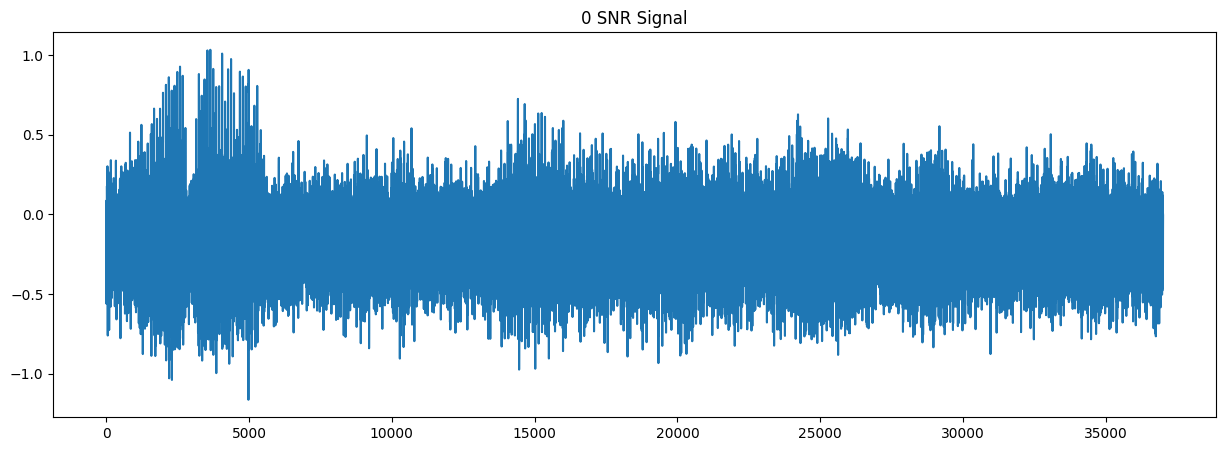

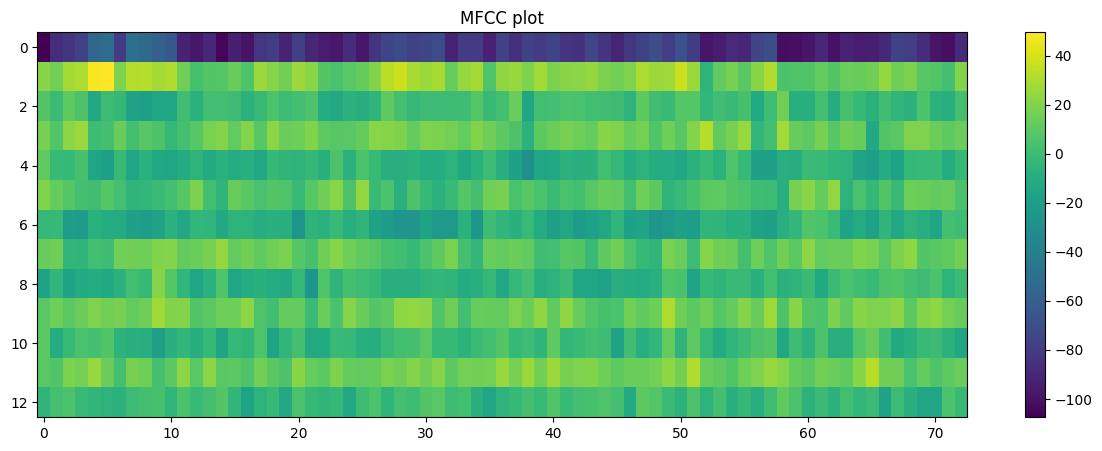

In [81]:
samples, fs = librosa.load("./audio/snr00_q4.wav", sr=16000)
plotSignal(samples, title="0 SNR Signal")
plotMFCC(samples, fs)

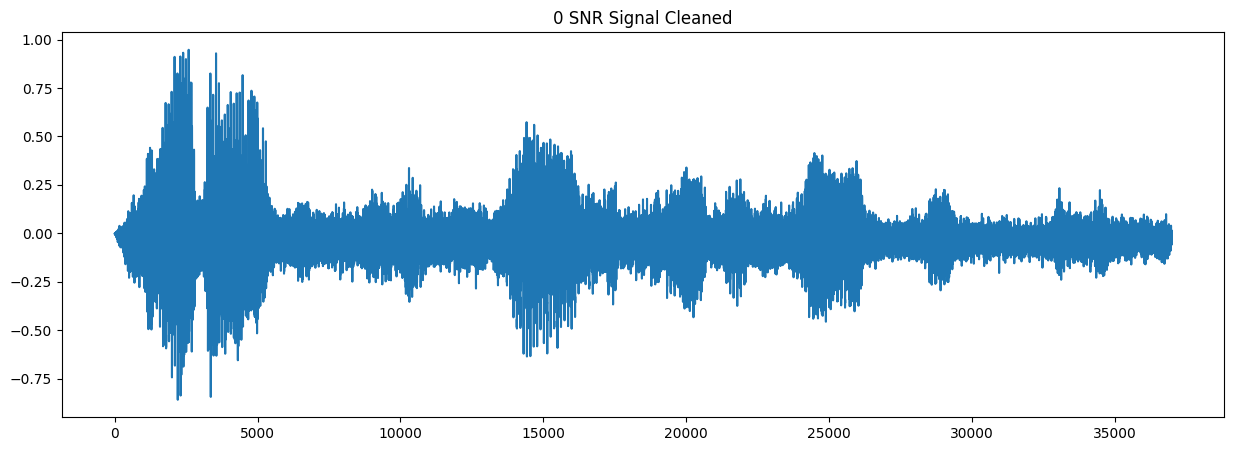

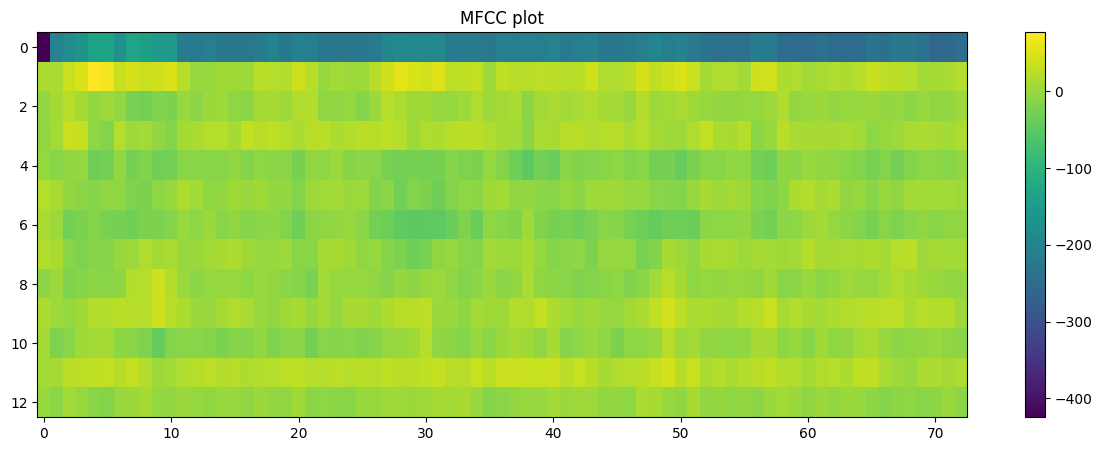

In [82]:
samples, fs = librosa.load("./audio/snr00_clean_q4.wav", sr=16000)
plotSignal(samples, title="0 SNR Signal Cleaned")
plotMFCC(samples, fs)

### 10 SNR Signal

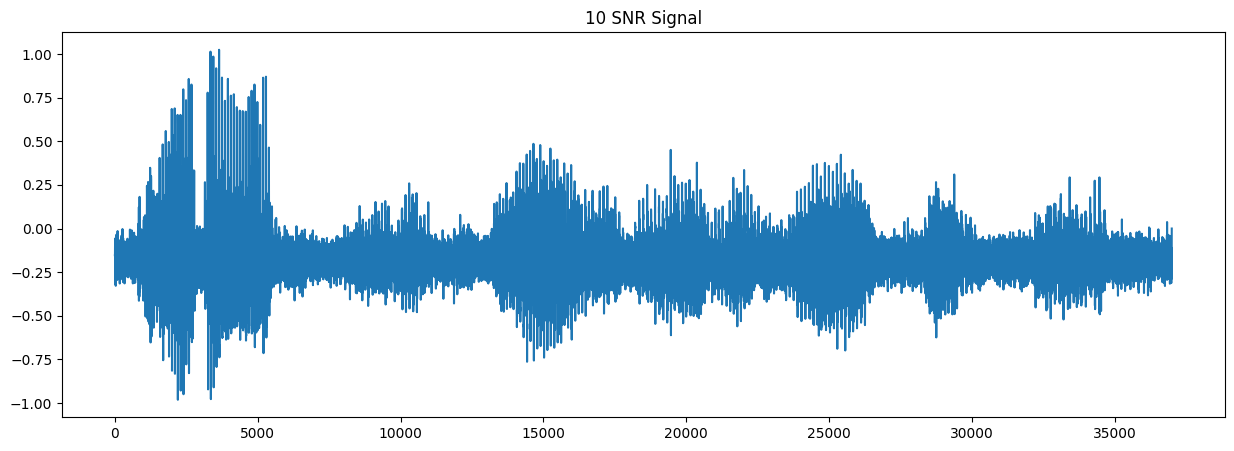

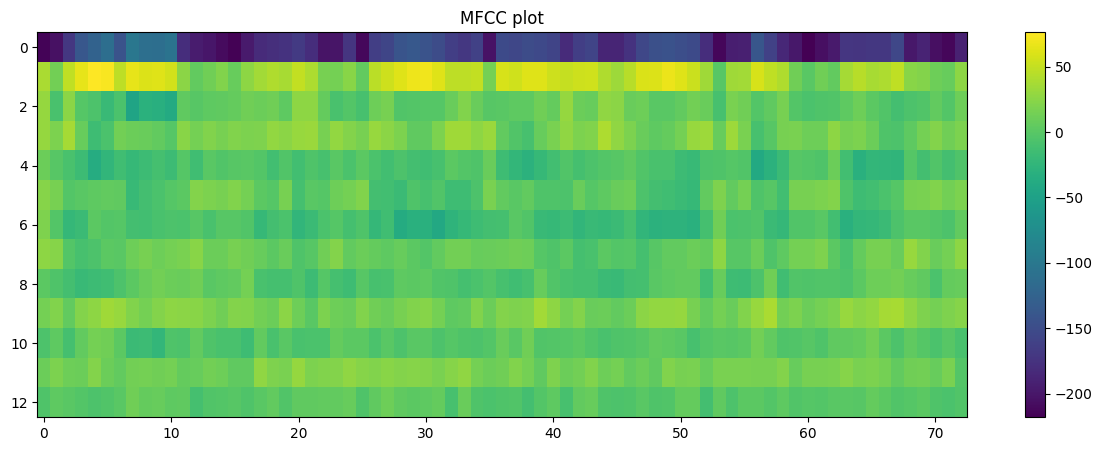

In [84]:
samples, fs = librosa.load("./audio/snr10_q4.wav", sr=16000)
plotSignal(samples, title="10 SNR Signal")
plotMFCC(samples, fs)

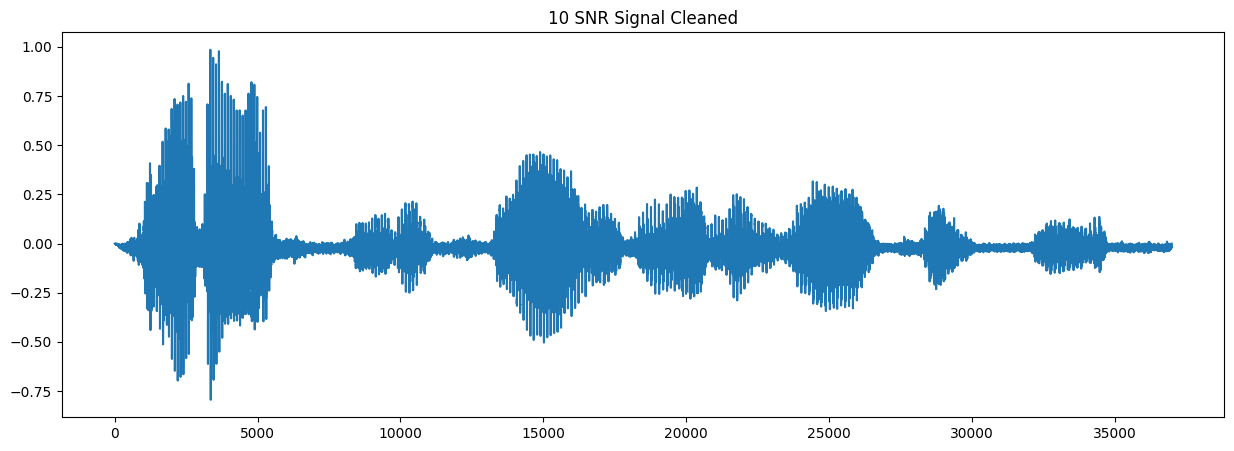

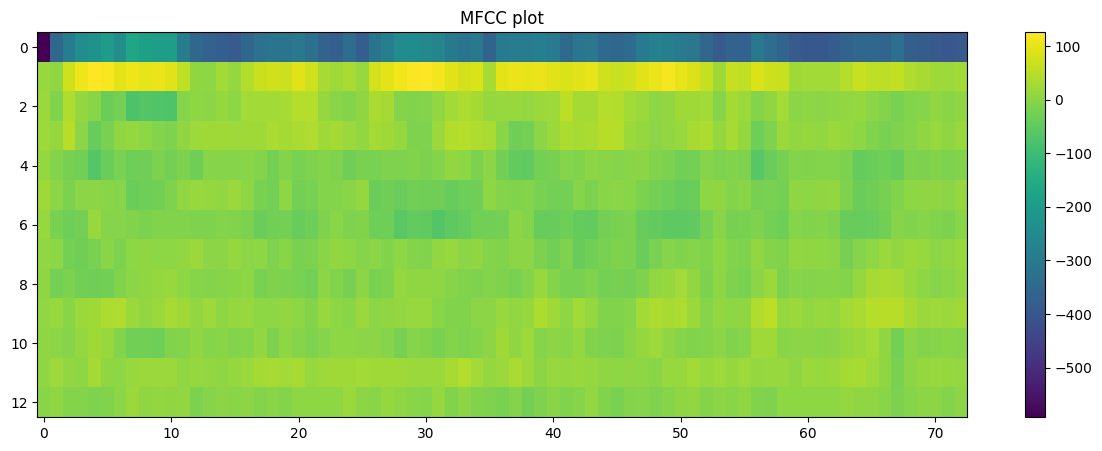

In [85]:
samples, fs = librosa.load("./audio/snr10_clean_q4.wav", sr=16000)
plotSignal(samples, title="10 SNR Signal Cleaned")
plotMFCC(samples, fs)

### 20 SNR Signal

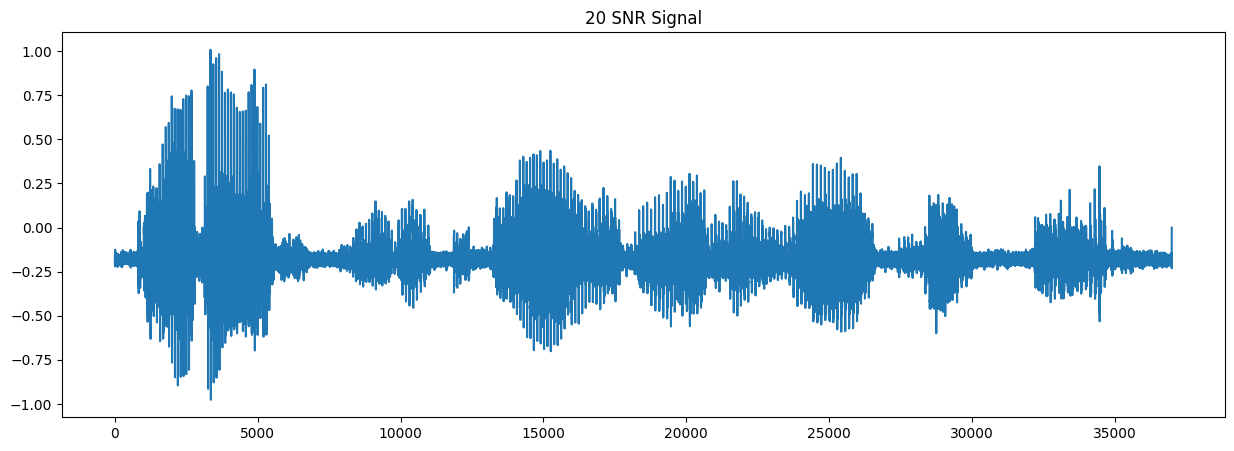

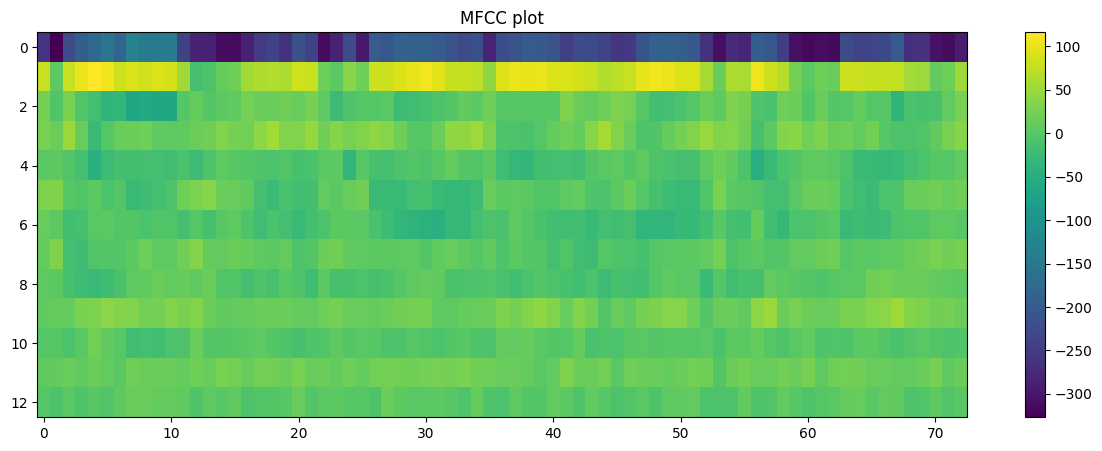

In [83]:
samples, fs = librosa.load("./audio/snr20_q4.wav", sr=16000)
plotSignal(samples, title="20 SNR Signal")
plotMFCC(samples, fs)

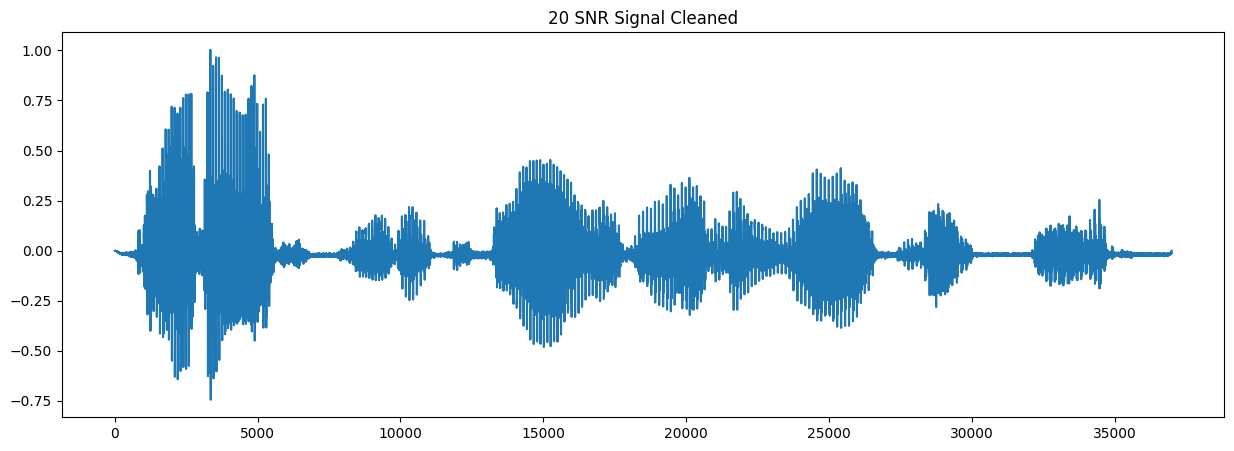

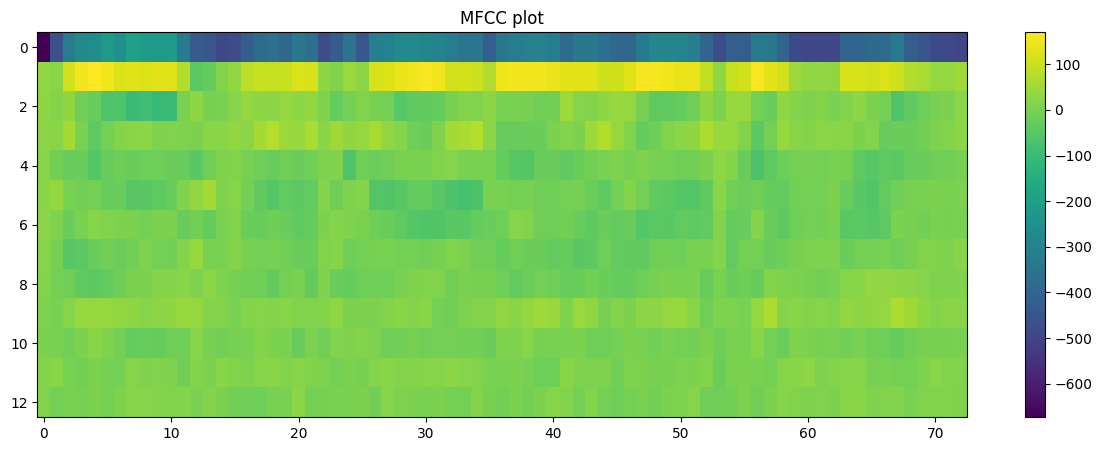

In [86]:
samples, fs = librosa.load("./audio/snr20_clean_q4.wav", sr=16000)
plotSignal(samples, title="20 SNR Signal Cleaned")
plotMFCC(samples, fs)